# Identifying Be-star X-ray binaries from X-ray variability

### Load libraries

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize as opt
from scipy.misc import factorial

import emcee
import corner

%matplotlib inline

### Load data

In [7]:
data = np.genfromtxt("../data/src_125.dat", names=True)
data = data[data['MJD'] > 53000.0]
print(data.dtype)


[('MJD', '<f8'), ('SRC_CNTS', '<f8'), ('BKG_CNTS', '<f8'), ('NET_CNTS', '<f8'), ('ERR_LOW', '<f8'), ('ERR_HIGH', '<f8')]


### Plot sample data

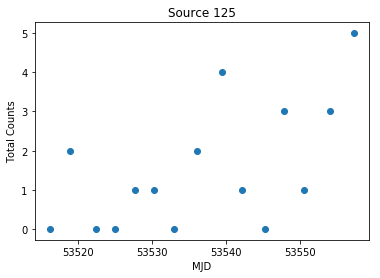

In [10]:
plt.scatter(data['MJD'], data['SRC_CNTS'])
plt.xlabel('MJD')
plt.ylabel('Total Counts')
plt.title('Source 125')
plt.show()

# Our model


We have a set of X-ray observations of high mass X-ray binaries (HMXBs) in M81, and we would like to identify, based on X-ray variability alone, which systems are likely to be Be-star X-ray binaries. 

Our model is a simple one: we assume that a Be-star X-ray binary has a quiescent luminosity well below the detection limit, such that any detected photons when the system is not in an outburst are due to the background. But any system in our sample *is* detected at a high significance. We therefore expect that any Be-star detected will only be detected during an outburst. Such outbursts typically last weeks. A Be-star X-ray binary is therefore characterized in the X-rays by a system that is consistent with having zero luminosity except for a brief time during outburst. 

So, we want to determine the likelihood that a particular set of observations of a detected system is consistent with having $L_x = 0$ except during an outburst. As a first attempt, we will model the outburst as a Gaussian, $L_x(t) = \mathcal{N}(t | \mu=t_0, \sigma=\Delta t)$ where $t_0$ is the time of the outburst, and $\Delta t$ is the length of outburst. Alternatively, we can try a couple other models, which we outline below:


1. Gaussian: $K(A, t_0, \Delta t) = A \exp{- \frac{1}{2} \mu^2}$ 
2. Epanechnikov: $K(A, t_0, \Delta t) = A \left( 1-\mu^2 \right)$ 
3. Exponential: $K(A, t_0, \Delta t) = A \exp{-(t-t_0) / \Delta t} H(t-t_0)$, where $H(t)$ is the heaviside step function


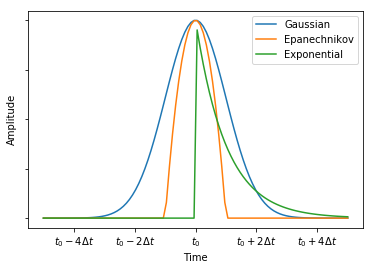

In [29]:
def gaussian(t, A, t0, delta_t):
    return A * np.exp(-(t-t0)**2/(2 * delta_t**2) )

def epanechnikov(t, A, t0, delta_t):
    y = A * (1.0 - (t-t0)**2 / delta_t**2) 
    return y * (y>0)
    
def exponential(t, A, t0, delta_t):
    return A * np.exp(-(t-t0)/(delta_t)) * (t>t0)
                    

t = np.linspace(0.0, 100.0, 100)
A = 1.0
t0 = 50.0
delta_t = 10.0

plt.plot(t, gaussian(t, A, t0, delta_t), label='Gaussian')
plt.plot(t, epanechnikov(t, A, t0, delta_t), label='Epanechnikov')
plt.plot(t, exponential(t, A, t0, delta_t), label='Exponential')

plt.yticks(np.linspace(0,1,5), [])
labels = [r'$t_0 - 4\Delta t$', r'$t_0 - 2\Delta t$', r'$t_0$', r'$t_0 + 2\Delta t$', r'$t_0 + 4\Delta t$']
plt.xticks(np.linspace(10,90,5), labels)


plt.legend(loc=1)
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.show()

### Now, let's put together some math

We start with Bayes' Theorem:

$$ P(M | D) \sim P(D | M) P(M), $$

where:

$$ P(D | M) = \prod_i^n P(D_i | M) $$

Each $D_i$ is an observation of one particular object. We are in the Poisson limit, since we have an integer number of counts. Therefore:

$$ P(D_i | M) = \frac{(\lambda_{b,i} + \lambda_{s,i})^{k_i}\ e^{-(\lambda_{b,i} + \lambda_{s,i})}}{k_i!}, $$

where $\lambda_{b,i}$ is the expected background for the $i$th observation (provided by the X-ray data reduction), and $\lambda_{s,i}$ is the expected source counts for the $i$th observation, determined from our model plotted above.

Therefore, $\lambda_{s,i} = K(t_i, A, t_0, \Delta t)$, where $K$ is the kernel chosen for the particular model at hand, and $A, t_0, \Delta t$ are the three parameters in our model.

Now, we have defined a likelihood function. To solve this, we can find the maximum likelihood result for each of our three kernels.

In [112]:
def poisson(mu, x):
    return mu**x * np.exp(-mu) / factorial(x)

def neg_ln_likelihood(x, data, kernel):
    return -ln_likelihood(x, data, kernel)

def ln_likelihood(x, data, kernel):

    A, t0, delta_t = x
    
    ln_likelihood = 0.0
    
    # Iterate through data
    for d in data:
        
        # Number of observed counts
        counts = d['SRC_CNTS']
        
        # Contribution to counts from the source
        lambda_source = kernel(d['MJD'], A, t0, delta_t)
        
        # Contribution to counts from the background
        lambda_background = d['BKG_CNTS']
        
        # Calculate the natural log of the poisson probability
#         ln_likelihood += counts * np.log(lambda_source+lambda_background) - len(data) * (lambda_source+lambda_background)
        ln_likelihood += np.log(poisson(lambda_source+lambda_background, counts))
    
    return ln_likelihood

In [113]:
# Initial values
A = 10.0
t0 = 0.8 * (np.max(data['MJD']) - np.min(data['MJD'])) + np.min(data['MJD'])
delta_t = 0.1*(np.max(data['MJD']) - np.min(data['MJD']))

x0 = np.array([A, t0, delta_t])
print("x0 =", x0)

bounds = [(0.01, 100.0), (np.min(data['MJD']), np.max(data['MJD'])), (2.0, 20.0)]
res = opt.minimize(neg_ln_likelihood, x0, args=(data, gaussian), bounds=bounds)

A_best, t0_best, delta_t_best = res.x
print("x_best =", A_best, t0_best, delta_t_best)

x0 = [  1.00000000e+01   5.35490932e+04   4.11690000e+00]
x_best = 2.83948889227 53557.327 15.7046780408


In [130]:
def ln_posterior(x, data, kernel):

    A, t0, delta_t = x
    
    # Prior
    if A < 0.01 or A > 100.0: return -np.inf
    if t0 < np.min(data['MJD']) or t0 > np.max(data['MJD']): return -np.inf
    if delta_t < 2.0 or delta_t > 20.0: return -np.inf
    
    # Likelihood
    ll = ln_likelihood(x, data, kernel)
    
    return ll


nwalkers = 32

# Initialize walkers
A_set = np.random.normal(loc = 10.0, scale=0.1, size=nwalkers)
t0_set = np.random.normal(loc = 0.5 * (np.max(data['MJD']) - np.min(data['MJD'])) + np.min(data['MJD']), scale=1.0, size=nwalkers)
delta_t_set = np.random.normal(loc = 0.1*(np.max(data['MJD']) - np.min(data['MJD'])), scale=0.1, size=nwalkers)
p0 = np.array([A_set, t0_set, delta_t_set]).T

# Run emcee
sampler_gaussian = emcee.EnsembleSampler(nwalkers=nwalkers, dim=3, lnpostfn=ln_posterior, args=[data, gaussian])
pos,prob,state = sampler_gaussian.run_mcmc(p0, N=500)


### Run emcee

In [166]:
print("Running Gaussian model...")
sampler_gaussian = emcee.EnsembleSampler(nwalkers=nwalkers, dim=3, lnpostfn=ln_posterior, args=[data, gaussian])
pos,prob,state = sampler_gaussian.run_mcmc(p0, N=1200)
print("... finished Gaussian model.")

print("Running Epanechnikov model...")
sampler_epan = emcee.EnsembleSampler(nwalkers=nwalkers, dim=3, lnpostfn=ln_posterior, args=[data, epanechnikov])
pos,prob,state = sampler_epan.run_mcmc(p0, N=1200)
print("... finished Epanechnikov model.")

print("Running exponential model...")
sampler_exp = emcee.EnsembleSampler(nwalkers=nwalkers, dim=3, lnpostfn=ln_posterior, args=[data, exponential])
pos,prob,state = sampler_exp.run_mcmc(p0, N=1200)
print("... finished exponential model.")

Running Gaussian model...
... finished Gaussian model.
Running Epanechnikov model...
... finished Epanechnikov model.
Running exponential model...
... finished exponential model.


### Plot walker movement

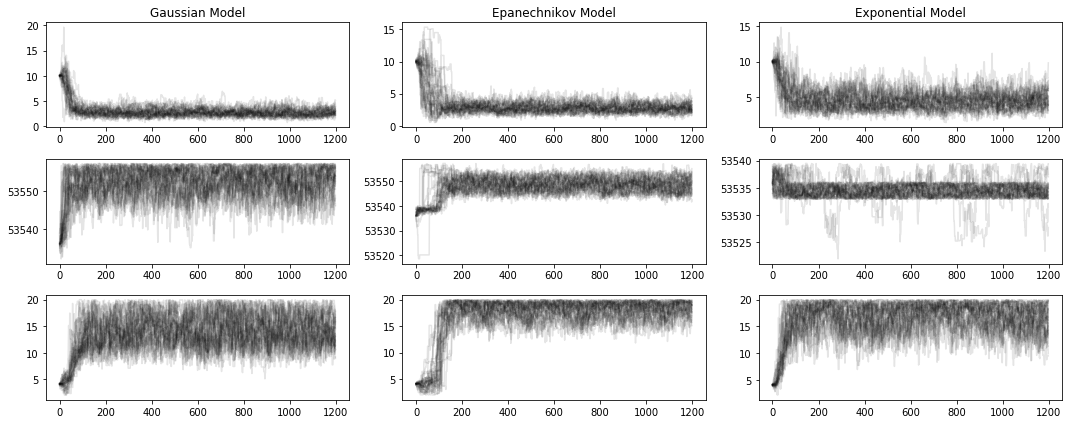

In [167]:

fig, ax = plt.subplots(3, 3, figsize=(15,6))

# Gaussian Model
n_chains, length, n_var = sampler_gaussian.chain.shape
ax[0,0].set_title('Gaussian Model')
for i in range(n_var):
    for j in range(n_chains):
        ax[i,0].plot(sampler_gaussian.chain[j,:,i], color='k', alpha=0.1)

# Epanechnikov Model
n_chains, length, n_var = sampler_epan.chain.shape
ax[0,1].set_title('Epanechnikov Model')
for i in range(n_var):
    for j in range(n_chains):
        ax[i,1].plot(sampler_epan.chain[j,:,i], color='k', alpha=0.1)

# Exponential Model
n_chains, length, n_var = sampler_exp.chain.shape
ax[0,2].set_title('Exponential Model')
for i in range(n_var):
    for j in range(n_chains):
        ax[i,2].plot(sampler_exp.chain[j,:,i], color='k', alpha=0.1)


plt.tight_layout()
plt.show()

In [168]:
# We remove the first 200 steps from each of the samplers as these are the burn-in

chain_gaussian_good = sampler_gaussian.chain[:,200:,:]
n_chains, length, n_var = chain_gaussian_good.shape
flat_chain_gaussian_good = chain_gaussian_good.reshape((n_chains*length, n_var))

chain_epan_good = sampler_epan.chain[:,200:,:]
n_chains, length, n_var = chain_epan_good.shape
flat_chain_epan_good = chain_epan_good.reshape((n_chains*length, n_var))

chain_exp_good = sampler_exp.chain[:,200:,:]
n_chains, length, n_var = chain_exp_good.shape
flat_chain_exp_good = chain_exp_good.reshape((n_chains*length, n_var))

### Plot covariance between parameter samples

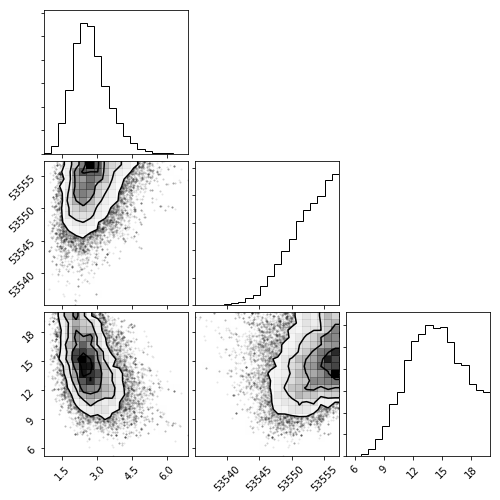

In [169]:
corner.corner(flat_chain_gaussian_good)
plt.show()

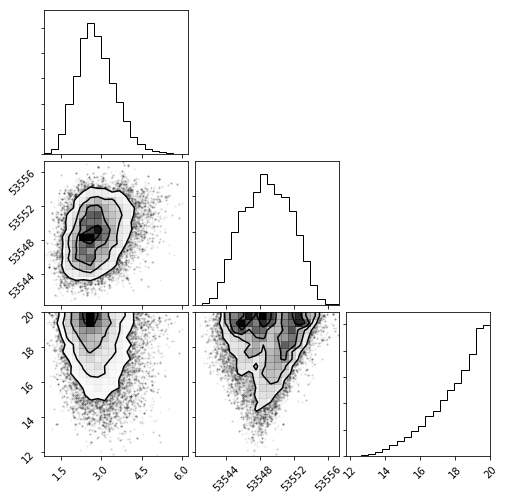

In [170]:
corner.corner(flat_chain_epan_good)
plt.show()

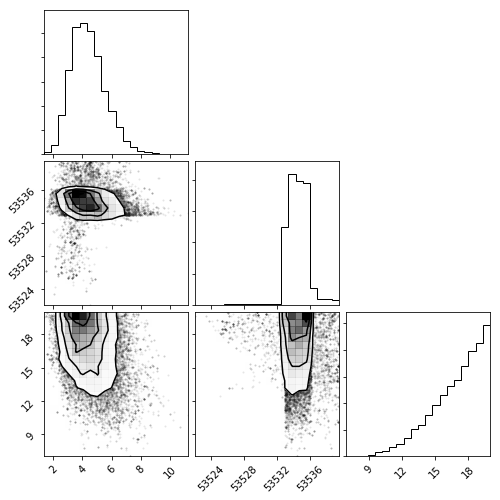

In [171]:
corner.corner(flat_chain_exp_good)
plt.show()

### Plot model and samples from the posterior

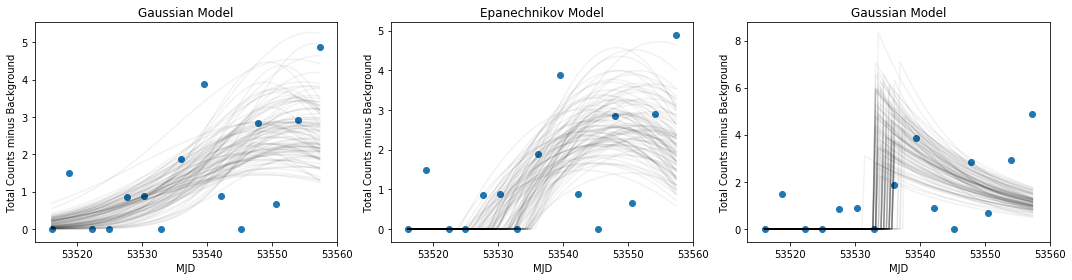

In [172]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))


times = np.linspace(np.min(data['MJD']), np.max(data['MJD']), 100)


# Gaussian
for idx in np.random.randint(len(flat_chain_gaussian_good.T[0]), size=100):    
    A, t0, delta_t = flat_chain_gaussian_good[idx]
    ax[0].plot(times, gaussian(times, A, t0, delta_t), color='k', alpha=0.05)
ax[0].set_title("Gaussian Model")

# Epanechnikov
for idx in np.random.randint(len(flat_chain_epan_good.T[0]), size=100):    
    A, t0, delta_t = flat_chain_epan_good[idx]
    ax[1].plot(times, epanechnikov(times, A, t0, delta_t), color='k', alpha=0.05)
ax[1].set_title("Epanechnikov Model")

# Exponential
for idx in np.random.randint(len(flat_chain_exp_good.T[0]), size=100):    
    A, t0, delta_t = flat_chain_exp_good[idx]
    ax[2].plot(times, exponential(times, A, t0, delta_t), color='k', alpha=0.05)
ax[2].set_title("Gaussian Model")


    
for i in range(3):
    ax[i].scatter(data['MJD'], data['NET_CNTS'])
    ax[i].set_xlabel('MJD')
    ax[i].set_ylabel('Total Counts minus Background')
# plt.title('Source 125')

plt.tight_layout()
plt.show()